# Train word2vec
- https://wikidocs.net/50739

## Use english dataset

### Import

In [1]:
import re
from lxml import etree
import urllib.request
import zipfile
from nltk.tokenize import word_tokenize, sent_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

### Load dataset

In [2]:
urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

('ted_en-20160408.zip', <http.client.HTTPMessage at 0x7fdad35245f8>)

In [3]:
# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    target_text = etree.parse(z.open('ted_en-20160408.xml', 'r'))
    parse_text = '\n'.join(target_text.xpath('//content/text()'))

In [4]:
parse_text[:300]

"Here are two reasons companies fail: they only do more of the same, or they only do what's new.\nTo me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.\nConsider Facit"

### Text preprocessing

In [5]:
# content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거, 괄호로 구성된 내용을 제거하면 됨
content_text = re.sub(r'\([^)]*\)', '', parse_text)

In [6]:
# 문장으로 나눔
sent_text = sent_tokenize(content_text)
len(sent_text)

273424

In [7]:
normalized_text = []
for string in sent_text:
    # 각 문장에 대해서 구두점을 제거(알파벳과 숫자만 남김)하고, 대문자를 소문자로 변환.
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

result = [word_tokenize(sentence) for sentence in normalized_text]
print(f"총 샘플의 수: {len(result)}")

총 샘플의 수: 273424


In [8]:
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


### Train Word2Vec

In [9]:
model = Word2Vec(
    sentences=result,
    size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1
)

In [10]:
model.wv.most_similar("apple")

[('atm', 0.6858340501785278),
 ('orchard', 0.6603444814682007),
 ('keynote', 0.6560966968536377),
 ('producer', 0.6499385833740234),
 ('mp3', 0.6483712196350098),
 ('iphone', 0.6470875144004822),
 ('album', 0.6470500230789185),
 ('seller', 0.6451087594032288),
 ('nico', 0.6432673931121826),
 ('dealer', 0.6410304307937622)]

### Save model

In [11]:
model.wv.save_word2vec_format('eng_w2v')

In [12]:
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v")
loaded_model.most_similar("man")

[('guy', 0.755164384841919),
 ('woman', 0.7510346174240112),
 ('soldier', 0.7021979093551636),
 ('michelangelo', 0.6809896230697632),
 ('rabbi', 0.6653515100479126),
 ('lady', 0.6651979684829712),
 ('baker', 0.6649072766304016),
 ('comedian', 0.6613531708717346),
 ('dancer', 0.6607744097709656),
 ('son', 0.6594641208648682)]

## Use korean dataset

### Import

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm

from gensim.models.word2vec import Word2Vec

### Load dataset

In [14]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fda93211f60>)

In [15]:
train_data = pd.read_table("ratings.txt")
train_data[:5]

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [16]:
train_data.isnull().values.any()

True

### Text preprocessing

In [17]:
train_data = train_data.dropna(how="any")
train_data.isnull().values.any()

False

In [18]:
len(train_data)

199992

In [19]:
# 한글만 남기기
train_data["document"] = train_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [20]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

100%|██████████| 199992/199992 [33:23<00:00, 99.83it/s] 


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


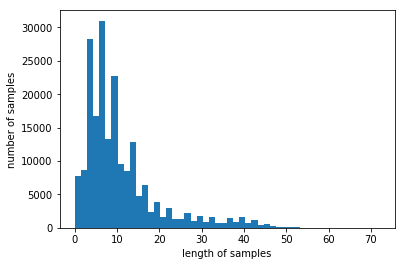

In [21]:
okt = Okt()
tokenized_data = []
for sentence in tqdm(train_data["document"]):
    temp_x = okt.morphs(sentence, stem=True)
    temp_x = [w for w in temp_x if w not in stopwords]
    tokenized_data.append(temp_x)

print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### Train word2vec

In [22]:
model = Word2Vec(
    sentences = tokenized_data, 
    size = 100, 
    window = 5, 
    min_count = 5, 
    workers = 4, 
    sg = 1
)

In [23]:
len(model.wv.vocab)

16477

In [24]:
model.wv.most_similar("영화")

[('판타지영화', 0.756276547908783),
 ('괴수영화', 0.7385435700416565),
 ('잉여', 0.729163646697998),
 ('쯔쯔', 0.7145744562149048),
 ('성인영화', 0.7120343446731567),
 ('에로물', 0.704147458076477),
 ('액션영화', 0.7025741338729858),
 ('양화', 0.7003703713417053),
 ('비급', 0.6977171897888184),
 ('놨', 0.6961220502853394)]

In [25]:
model.wv.most_similar("한국")

[('우리나라', 0.8674337863922119),
 ('일본', 0.7492265701293945),
 ('미국', 0.7171658277511597),
 ('대한민국', 0.7083633542060852),
 ('중국', 0.7074199914932251),
 ('국산', 0.7038429379463196),
 ('외국', 0.7006456255912781),
 ('양산', 0.6975690126419067),
 ('국내', 0.67430180311203),
 ('태국', 0.6666800379753113)]

In [26]:
model.wv.most_similar("마블")

[('러시아워', 0.8459465503692627),
 ('캐리비안', 0.8385698199272156),
 ('에반게리온', 0.8372493982315063),
 ('블레이드', 0.8191103935241699),
 ('다이하드', 0.818717360496521),
 ('명탐정', 0.8145815134048462),
 ('스타워즈', 0.8097450733184814),
 ('히어로', 0.8065754175186157),
 ('로맨스코미디', 0.8060736060142517),
 ('으뜸', 0.8034007549285889)]